In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df = pd.read_csv('diabetes.csv')

### Train and evaluate both models.

In [3]:
target_col = 'Outcome' if 'Outcome' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(int)

zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
cols_to_fix = [c for c in zero_as_missing if c in X.columns]
if cols_to_fix:
    X[cols_to_fix] = X[cols_to_fix].replace(0, np.nan)
    imputer = SimpleImputer(strategy='median')
    X[cols_to_fix] = imputer.fit_transform(X[cols_to_fix])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000, solver="liblinear", random_state=42))
])

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=11, weights="distance", p=2))
])

lr_pipe.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)

def eval_model(name, model):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, y_score)
    print(f"{name} — Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {auc:.3f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    return auc

auc_lr = eval_model("Logistic Regression", lr_pipe)
auc_knn = eval_model("K-NN", knn_pipe)

Logistic Regression — Accuracy: 0.734  Precision: 0.603  Recall: 0.704  F1: 0.650  ROC-AUC: 0.813
Confusion matrix:
[[75 25]
 [16 38]]
K-NN — Accuracy: 0.734  Precision: 0.633  Recall: 0.574  F1: 0.602  ROC-AUC: 0.793
Confusion matrix:
[[82 18]
 [23 31]]


c:\Python313\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

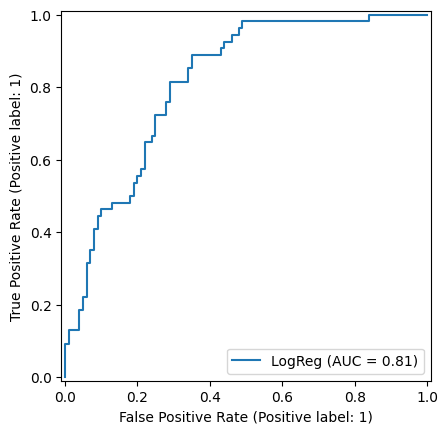

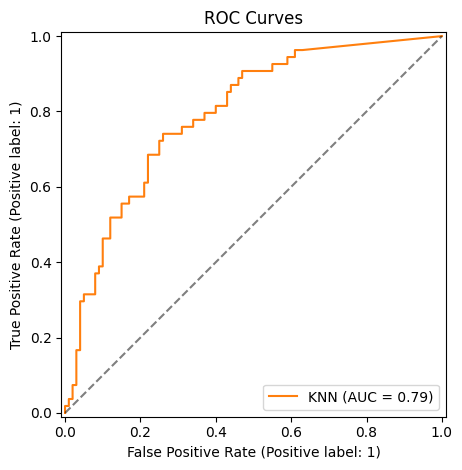

In [4]:
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(lr_pipe, X_test, y_test, name="LogReg", color="tab:blue")
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, name="KNN", color="tab:orange")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.title("ROC Curves")
plt.tight_layout()
plt.show()

### Compare their accuracy, precision, recall, and F1-score.

In [5]:
y_pred_lr = lr_pipe.predict(X_test)
y_pred_knn = knn_pipe.predict(X_test)

def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return acc, prec, rec, f1

acc_lr, prec_lr, rec_lr, f1_lr = get_metrics(y_test, y_pred_lr)
acc_knn, prec_knn, rec_knn, f1_knn = get_metrics(y_test, y_pred_knn)

metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-NN'],
    'Accuracy': [acc_lr, acc_knn],
    'Precision': [prec_lr, prec_knn],
    'Recall': [rec_lr, rec_knn],
    'F1': [f1_lr, f1_knn]
})
metrics_df

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.733766,0.603175,0.703704,0.649573
1,K-NN,0.733766,0.632653,0.574074,0.601942


### Logistic Regression is better because its F1 Score is bigger (0.65 vs 0.60).  
### It also has higher recall (0.70 vs 0.57), meaning it finds more true positives.  
### K-NN has a bit higher precision (0.63 vs 0.60), so its positive predictions are slightly more accurate, but it misses more actual positives.  
### Overall, Logistic Regression gives a better balance between precision and recall.